In [75]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pandas as pd
from collections import Counter
pd.set_option('display.max_columns', 50)
from googletrans import Translator
from tqdm import tqdm
import datetime

In [76]:
orders = pd.read_csv('Data/Processed/orders.csv', encoding='utf-8')

In [77]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,seller_id,product_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,credit_card,1.0,18.12,7c396fd4830fd04220f754e42b4e5bff,3149.0,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,O cliente não comentou,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,3504c0cb71d7fa48d967e0e4c94d59d9,87285b34884572647811a353c7ac498a,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,boleto,1.0,141.46,af07308b275d755c9edb36a90c618231,47813.0,barreiras,BA,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1.0,289cdb325fb7e7f891c38608bf9e0962,595fac2a385ac33a80bd5114aec74eb8,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,credit_card,3.0,179.12,3a653a41f6f9fc3d2a113cf8398680e8,75265.0,vianopolis,GO,e73b67b67587f7644d5bd1a52deb1b01,5.0,O cliente não comentou,O cliente não comentou,2018-08-18 00:00:00,2018-08-22 19:07:58,1.0,4869f7a5dfa277a7dca6462dcf3b52b2,aa4383b373c6aca5d8797843e5594415,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,credit_card,1.0,72.20,7c142cf63193a1473d2e66489a9ae977,59296.0,sao goncalo do amarante,RN,359d03e676b3c069f62cadba8dd3f6e8,5.0,O cliente não comentou,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58,1.0,66922902710d126a0e7d26b0e3805106,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-23 19:45:59,45.00,27.20,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,credit_card,1.0,28.62,72632f0f9dd73dfee390c9b22eb56dd6,9195.0,santo andre,SP,e50934924e227544ba8246aeb3770dd4,5.0,O cliente não comentou,O cliente não comentou,2018-02-17 00:00:00,2018-02-18 13:02:51,1.0,2c9e548be18521d1c43cde1c582c6de8,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-19 20:31:37,19.90,8.72,papelaria,38.0,316.0,4.0,250.0,51.0,15.0,15.0


In [78]:
def validate(date_text):
    try:
        if date_text != datetime.datetime.strptime(date_text, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S'):
            raise ValueError
        return True
    except ValueError:
        return False
    
clean_orders = orders[orders['order_purchase_timestamp'].apply(validate) == True]
clean_orders = clean_orders[clean_orders['order_approved_at'].apply(validate) == True]
clean_orders = clean_orders[clean_orders['order_delivered_carrier_date'].apply(validate) == True]
clean_orders = clean_orders[clean_orders['order_estimated_delivery_date'].apply(validate) == True]

In [79]:
clean_orders = clean_orders.astype({"order_status" : 'category', \
                       "order_purchase_timestamp" : 'datetime64[ns]', 
                        "order_approved_at" : 'datetime64[ns]', \
                       "order_delivered_carrier_date" : 'datetime64[ns]', 
                        "order_delivered_customer_date" : 'datetime64[ns]', \
                       "order_estimated_delivery_date" : 'datetime64[ns]', 
                        'review_creation_date':'datetime64[ns]', \
                        "review_answer_timestamp" : 'datetime64[ns]', "shipping_limit_date" : 'datetime64[ns]', \
                        "product_category_name" : 'category', 
                       })

## 1. RFM analysis of Olist's Sellers

https://towardsdatascience.com/apply-rfm-principles-to-cluster-customers-with-k-means-fef9bcc9ab16

Here, RFM stands for :
- Recency — How recently did the seller sell an item?
- Frequency — How often do they sell items ?
- Monetary Value — How much do they bring in revenue ?

Seller sales may be represented by a table with columns for the seller name, date of sale and sale value. One approach to RFM is to assign a score for each dimension on a scale from 1 to 5. The maximum score represents the preferred behavior and a formula could be used to calculate the three scores for each seller.

- To calculate recency, we'll look into the invoice dates. We'll consider the last invoice as the most recent one. Then, we’ll subtract each day from the day after to calculate the other 'recencies'.

- To calculate frequency, we'll sum the invoice numbers for each sellers. 

- For the monetary value, we will sum the total order price for each seller.

Finally, we will segment the value range of each dimension to assign score from 1 to 5 to each seller.

In [80]:
print('Most recent invoice is from:')
print(clean_orders['order_approved_at'].max())

print('Least recent invoice is from :')
print(clean_orders['order_approved_at'].min())


lastDate = clean_orders['order_approved_at'].max()
clean_orders['InvoiceDate'] = clean_orders['order_approved_at']

Most recent invoice is from:
2018-08-29 15:10:26
Least recent invoice is from :
2016-10-04 09:43:32


In [81]:
clean_orders['Total_price'] = clean_orders['price'] + clean_orders['freight_value']

In [82]:
rfmTable = clean_orders.groupby('seller_id').agg({'InvoiceDate': lambda x: (lastDate - x.max()).days, 
                                                  'Total_price': lambda x: x.sum()})

rfmTable['InvoiceNo'] = clean_orders.groupby('seller_id').apply(lambda x : len(x))
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Total_price': 'monetary'}, inplace=True)

rfmTable.head()

,recency,monetary,frequency
seller_id,,,
0015a82c2db000af6aaaf3ae2ecb0532,314,2748.06,3
001cca7ae9ae17fb1caed9dfb1094831,47,32968.37,194
002100f778ceb8431b7a1020ff7ab48f,139,2093.36,49
003554e2dce176b5555353e4f3555ac8,257,139.38,1
004c9cd9d87a3c30c522c48c4fc07416,116,22068.48,147


Now, we have to calculate the scores.

We order the data by frequency in descending mode. Then, we divide the number of sellers on the data set by 5. We assign a number from 5 to 1 to each one of the previously created segments. Same for monetary and recency columns too.

For the recency column, since the most recent orders are better, we will order it as ascending.

In [83]:
# Create f_score

f_score = []
m_score = []
r_score = []

columns = ['frequency', 'monetary']
scores_str = ['f_quartile', 'm_quartile']
scores = [f_score, m_score]
N = rfmTable.shape[0] #number of sellers

for n in range(len(columns)):
    # Order by column
    rfmTable = rfmTable.sort_values(columns[n], ascending=False)
    
    # Create new index
    refs = np.arange(N)
    rfmTable['refs'] = list(refs)
    
    segment = int(N / 5)
    # Add score
    for i, row in rfmTable.iterrows():
        if row['refs'] <= segment:
            scores[n].append(5)
        elif row['refs'] > segment and row['refs'] <= segment*2:
            scores[n].append(4)
        elif row['refs'] > segment*2 and row['refs'] <= segment*3:
            scores[n].append(3)
        elif row['refs'] > segment*3 and row['refs'] <= segment*4:
            scores[n].append(2)
        else: 
            scores[n].append(1)

    # Create f_score column
    rfmTable[scores_str[n]] = scores[n]
    
# For recency, we do the opposite: most recents are better, so we order as ascending
rfmTable = rfmTable.sort_values('recency', ascending=True)
    
# Recreate index
refs = np.arange(N)
rfmTable['refs'] = refs
    
# Add score
for i, row in rfmTable.iterrows():
    if row['refs'] <= segment:
        r_score.append(5)
    elif row['refs'] > segment and row['refs'] <= segment*2:
        r_score.append(4)
    elif row['refs'] > segment*2 and row['refs'] <= segment*3:
        r_score.append(3)
    elif row['refs'] > segment*3 and row['refs'] <= segment*4:
        r_score.append(2)
    else: 
        r_score.append(1)

# Create r_score column
rfmTable['r_quartile'] = r_score

In [84]:
rfmTable.head()

,recency,monetary,frequency,refs,f_quartile,m_quartile,r_quartile
seller_id,,,,,,,
c70c1b0d8ca86052f45a432a38b73958,0,39779.25,256,0,5,5,5
c731d18cea9bf687ffee82a241c25b11,0,4633.39,23,1,4,4,5
4e922959ae960d389249c378d1c939f5,0,52585.10,412,2,5,5,5
7dc8c42cc750eeafea6c85712ffee9bf,0,7594.72,41,3,5,5,5
54583ab379489add547fe47b628db589,0,2391.08,10,4,3,4,5


In [85]:
rfmTable['RFMScore'] = rfmTable.r_quartile.map(str) \
                            + rfmTable.f_quartile.map(str) \
                            + rfmTable.m_quartile.map(str)

**Top 10 Sellers**

In [86]:
top10 = rfmTable[rfmTable['RFMScore'] == '555'].sort_values('monetary', ascending=False).head(10)

In [87]:
top10

,recency,monetary,frequency,refs,f_quartile,m_quartile,r_quartile,RFMScore
seller_id,,,,,,,,
4869f7a5dfa277a7dca6462dcf3b52b2,4,247634.47,1115,192,5,5,5,555
4a3ca9315b744ce9f8e9374361493884,2,232423.08,1717,115,5,5,5,555
53243585a1d6dc2643021fd1853d8905,7,230797.02,348,431,5,5,5,555
fa1c13f2614d7b5c4749cbc52fecda94,0,200044.11,571,26,5,5,5,555
da8622b14eb17ae2831f4ac5b9dab84a,0,182482.13,1278,25,5,5,5,555
1025f0e2d44d7041d6cf58b6550e0bfa,3,171541.24,892,154,5,5,5,555
7a67c85e85bb2ce8582c35f2203ad736,7,160720.88,1131,426,5,5,5,555
955fee9216a65b617aa5c0531780ce60,0,156609.41,1254,20,5,5,5,555
6560211a19b47992c3666cc44a7e94c0,0,148994.13,1804,19,5,5,5,555


**Bottom 10 sellers**

In [88]:
bottom10 = rfmTable[rfmTable['RFMScore'] == '111'].sort_values('monetary', ascending=True).head(10)

In [89]:
bottom10

,recency,monetary,frequency,refs,f_quartile,m_quartile,r_quartile,RFMScore
seller_id,,,,,,,,
77128dec4bec4878c37ab7d6169d6f26,531,15.22,1,2848,1,1,1,111
702835e4b785b67a084280efca355756,561,18.56,1,2890,1,1,1,111
ad14615bdd492b01b0d97922e87cb87f,564,19.21,1,2896,1,1,1,111
7ab0dd5487bab2dc835337b244f689fb,510,23.46,1,2824,1,1,1,111
c18309219e789960add0b2255ca4b091,267,24.00,1,2383,1,1,1,111
5b92bfa4120daa27c574daa2e386c693,555,24.96,1,2881,1,1,1,111
20d53aad4fe5ee93a64f8839609d3586,276,26.98,1,2417,1,1,1,111
9e25199f6ef7e7c347120ff175652c3b,520,27.02,1,2834,1,1,1,111
0f94588695d71662beec8d883ffacf09,546,27.59,1,2870,1,1,1,111


**Some statistics**

In [90]:
print("Best Sellers: ",len(rfmTable[rfmTable['RFMScore'] == '555']))
print('Active Sellers:', len(rfmTable[rfmTable['f_quartile'] == 5]))
print("Big MoneyMaker: ",len(rfmTable[rfmTable['m_quartile']==5]))
print('inactive Sellers: ',len(rfmTable[rfmTable['r_quartile']==1]))
print('Inactive and Cheap Sellers: ',len(rfmTable[rfmTable['RFMScore']=='111']))
print('Total Number of sellers : ', rfmTable.shape[0])

Best Sellers:  229
Active Sellers: 592
Big MoneyMaker:  592
inactive Sellers:  593
Inactive and Cheap Sellers:  169
Total Number of sellers :  2958


## 2. Does our RFM analysis of the sellers reflect discussed topics during Customer Sentiment Analysis ? 

We will consider the best/worst sellers from the RFM analysis while considering only good reviews (score>=5) and bad reviews  (score <= 3) in order to point out problems.

In [91]:
best_sellers = list(rfmTable[rfmTable['RFMScore'] == '555'].reset_index().seller_id)
best_sellers = clean_orders[clean_orders['seller_id'].apply(lambda x : x in best_sellers)]

In [92]:
worst_sellers = list(rfmTable[rfmTable['RFMScore'] < '333'].reset_index().seller_id)
worst_sellers = clean_orders[clean_orders['seller_id'].apply(lambda x : x in worst_sellers)]

### 2.1 Do the worst sellers sell lower quality product than best sellers ? 

We use the trigram generated during customer sentiment analysis and try to find whether they appear here.

In [93]:
best_sellers['comment_present'] = best_sellers.review_comment_message != 'O cliente não comentou'
worst_sellers['comment_present'] = worst_sellers.review_comment_message != 'O cliente não comentou'

#Look only orders with customer review comment
best_sellers_commented = best_sellers[best_sellers['comment_present'] == True]
worst_sellers_commented = worst_sellers[worst_sellers['comment_present'] == True]

N_best = best_sellers_commented.shape[0]
N_worst = worst_sellers_commented.shape[0]

N_best, N_worst

C:\Anaconda\envs\ada\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda\envs\ada\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(20503, 5478)

Discussion : We notice that the difference in number of orders between best sellers and worst sellers is quite important, as expected, the latter having a quite low number of orders. Below is the total number of orders without comment filtering.

In [94]:
best_sellers.shape[0], worst_sellers.shape[0]

(50279, 13186)

In [95]:
bad_product_trigram = ['quero dinheiro volta', 'produto veio defeito', 'recebi produto errado', 'produto veio errado', 'produto pessima qualidade' ]

In [96]:
n = 0
for m in best_sellers_commented.review_comment_message : 
    for bad in bad_product_trigram :
        if(bad in m) : 
            n+=1

In [97]:
print('We look at the best sellers identified from RFM analysis. There are {} review messages pointing out the bad quality of the received products out of the {} commented review. Hence, there are {} % of bad quality products.'\
      .format(n, N_best, round(n/N_best * 100, 2)))

We look at the best sellers identified from RFM analysis. There are 21 review messages pointing out the bad quality of the received products out of the 20503 commented review. Hence, there are 0.1 % of bad quality products.


In [98]:
n = 0
for m in worst_sellers_commented.review_comment_message : 
    for bad in bad_product_trigram :
        if(bad in m) : 
            n+=1

In [99]:
print('We look at the worst sellers identified from RFM analysis. There are {} review messages pointing out the bad quality of the received products out of the {} commented review. Hence, there are {} % of bad quality products.'\
      .format(n, N_worst, round(n/N_worst * 100, 2)))

We look at the worst sellers identified from RFM analysis. There are 8 review messages pointing out the bad quality of the received products out of the 5478 commented review. Hence, there are 0.15 % of bad quality products.


**When looking at the numbers, although worst sellers sell less in magnitude, which has to be a consequence of bad customer experience, it seems that they tend to sell more low quality products than best sellers.**

### 2.2 Is the delivery delay an important element in determining whether a seller is good or not ? 

#### 2.2.3 Can Customer sentiment analysis tell us something ? 

In [100]:
late_deliveries_trigram = ['nao recebi produto', 'ainda nao recebi', 'produto nao entregue', 'produto nao chegou', 'produto ainda nao', 
                          'ainda nao chegou', 'momento nao recebi', 'ainda nao entregue', 'agora nao recebi', 'recebi produto nao',
                          'nao recebi mercadoria', 'recebi produto ainda', 'hoje nao recebi']

In [101]:
n = 0
for m in best_sellers_commented.review_comment_message : 
    for l in late_deliveries_trigram :
        if(l in m) : 
            n+=1

In [102]:
print('We look at the best sellers identified from RFM analysis. There are {} review messages pointing out late deliveries out of the {} commented review. Hence, there are {} % of orders which arrived late.'\
      .format(n, N_best, round(n/N_best * 100, 2)))

We look at the best sellers identified from RFM analysis. There are 37 review messages pointing out late deliveries out of the 20503 commented review. Hence, there are 0.18 % of orders which arrived late.


In [103]:
n = 0
for m in worst_sellers_commented.review_comment_message : 
    for l in late_deliveries_trigram :
        if(l in m) : 
            n+=1

In [104]:
print('We look at the worst sellers identified from RFM analysis. There are {} review messages pointing out late deliveries out of the {} commented review. Hence, there are {} % of orders which arrived late.'\
      .format(n, N_worst, round(n/N_worst * 100, 2)))

We look at the worst sellers identified from RFM analysis. There are 10 review messages pointing out late deliveries out of the 5478 commented review. Hence, there are 0.18 % of orders which arrived late.


#### 2.2.3 Can silent customers tell us more about it ? 

Let's have a look at the distribution of late deliveries in days between best and worst sellers.
An order is identified being late when the 'order_delivered_customer_date' is bigger than the 'order_estimated_delivery_date'. Hence, when their difference is positive.

In [105]:
best_sellers['late_delivery'] = (best_sellers['order_delivered_customer_date'] - best_sellers['order_estimated_delivery_date']).dt.days

C:\Anaconda\envs\ada\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [106]:
worst_sellers['late_delivery'] = (worst_sellers['order_delivered_customer_date'] - worst_sellers['order_estimated_delivery_date']).dt.days

C:\Anaconda\envs\ada\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


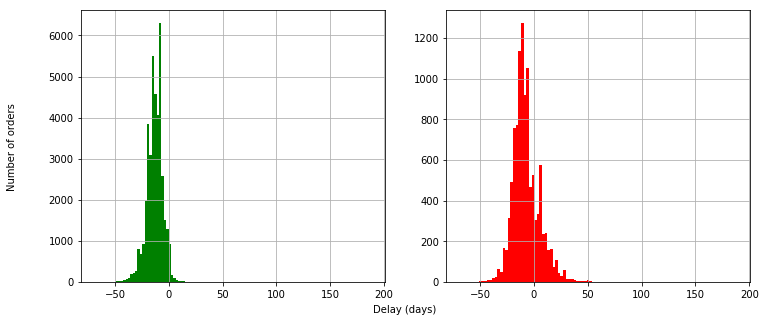

In [107]:
dims = (12, 5)
fig, ax =plt.subplots(1,2,figsize=dims, sharex=True)
fig.text(0.5, 0.04, 'Delay (days)', ha='center')
fig.text(0.04, 0.5, 'Number of orders', va='center', rotation='vertical')

#fig.suptitle('Distribution of late deliveries in days between good (left) and bad (right) review orders for best sellers')

best_sellers[best_sellers['review_score'] >= 4].late_delivery.hist(bins=100, ax=ax[0], color = "green", lw=0)
best_sellers[best_sellers['review_score'] < 4].late_delivery.hist(bins=100, ax=ax[1], color = "red", lw=0)
plt.savefig(fname='late_deliveries_best_sellers.eps',format='eps')
plt.show()

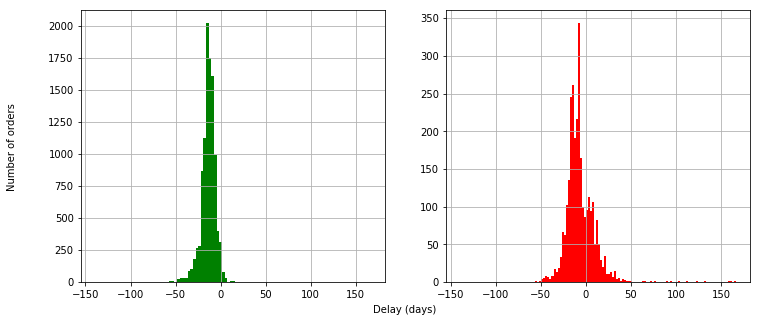

In [108]:
dims = (12, 5)
fig, ax =plt.subplots(1,2,figsize=dims, sharex=True)
fig.text(0.5, 0.04, 'Delay (days)', ha='center')
fig.text(0.04, 0.5, 'Number of orders', va='center', rotation='vertical')

#fig.suptitle('Distribution of late deliveries in days between good (left) and bad (right) review orders for worst sellers')

worst_sellers[worst_sellers['review_score'] >= 4].late_delivery.hist(bins=100, ax=ax[0], color = "green", lw=0)
worst_sellers[worst_sellers['review_score'] < 4].late_delivery.hist(bins=100, ax=ax[1], color = "red", lw=0)
plt.savefig(fname='late_deliveries_worst_sellers.eps',format='eps')
plt.show()

Although the distribution are quite similar between best and worst sellers, we notice that within best and worst sellers, late delivery is actually an important element making the decision for an order review score.

## 3. Spotting the late delivers !

While during the first part we identified best and worst sellers, the rfm analysis did not take into account customer sentiment analysis. Using our previous conclusion about this, one might be interested to further seller analysis by spotting the sellers who often delivers orders late. This can be used as a driver for stakeholders to either warn best sellers who gets too confident about their position and popularity at the expense of olist platform popularity when not taking into account customer reviews, or by discarding those bad sellers who do not bring that much value to the company and at the same time tarnish the reputation of the platform.

In [109]:
best_sellers_delivery = best_sellers.groupby('seller_id').agg({'late_delivery' : 'mean'})
late_delivers = best_sellers_delivery[best_sellers_delivery['late_delivery'] >= 1]
print('There is {} sellers among best ones with an average delivery delay of more than 1 day'.format(late_delivers.shape[0]))

There is 0 sellers among best ones with an average delivery delay of more than 1 day


In [110]:
worst_sellers_delivery = worst_sellers.groupby('seller_id').agg({'late_delivery' : 'mean'})
late_delivers = worst_sellers_delivery[worst_sellers_delivery['late_delivery'] > 1]
print('There are {} sellers among worst ones with an average delivery delay of more than 1 day'.format(late_delivers.shape[0]))

There are 74 sellers among worst ones with an average delivery delay of more than 1 day


In [111]:
late_delivers.sort_values(by='late_delivery', ascending = False).head(10)

,late_delivery
seller_id,
df683dfda87bf71ac3fc63063fba369d,167.000000
a154d7316f158bb42e6fa18bbe3afd3a,42.000000
e09887ca8c7bf8a4621ce481820414ef,41.000000
8e670472e453ba34a379331513d6aab1,35.000000
4fb41dff7c50136976d1a5cf004a42e2,33.000000
8629a7efec1aab257e58cda559f03ba7,33.000000
6f1a1263039c76e68f40a8e536b1da6a,31.000000
eebb3372362aa9a46975164bed19a7e7,27.000000
391bbd13b6452244774beff1824006ed,24.000000
